In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from prophet.diagnostics import cross_validation, performance_metrics
from suntime import Sun, SunTimeException
from datetime import timedelta
import ephem
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score
import mlflow

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv("/workspaces/Powerbox/timeseries.csv")
df.head()

,Unnamed: 0,Timestamp,System ON,System ON Timestamps,System OFF Timestamps,Temperature (°C),Solar Panels Energy Output (W),Power Consumption (kW),Energy Stored in Batteries (kWh),Inverter Efficiency (%),...,Battery Full Flag,Customer Profile,User Coordinates,Solar Panels Type,Solar Panels Configuration,Depth of Discharge,Battery Capacity (Wh),Inverter Capacity (kW),Battery Technology,Solar Irradiance (W/m²)
0,1,05/09/2024 00:00,True,05/09/2024 00:00,NaN,21.027232,0.0,0.232676,0.767498,90.0,...,False,Residential,"10.525053,7.417248",MonoCrystalline,1s2p,10%,1000.0,1.0,Lithium - Ion,NaN
1,3,05/09/2024 00:15,True,05/09/2024 00:15,NaN,21.000000,0.0,0.398544,0.709329,90.0,...,False,Residential,"10.525053,7.417249",MonoCrystalline,1s2p,10%,1000.0,1.0,Lithium - Ion,NaN
2,5,05/09/2024 00:30,True,05/09/2024 00:30,NaN,21.954235,0.0,0.530610,0.609693,90.0,...,False,Residential,"10.525053,7.417250",MonoCrystalline,1s2p,10%,1000.0,1.0,Lithium - Ion,NaN
3,7,05/09/2024 00:45,True,05/09/2024 00:45,NaN,22.692779,0.0,0.417322,0.477041,90.0,...,False,Residential,"10.525053,7.417251",MonoCrystalline,1s2p,10%,1000.0,1.0,Lithium - Ion,NaN
4,9,05/09/2024 01:00,True,05/09/2024 01:00,NaN,22.200476,0.0,0.314497,0.372710,90.0,...,False,Residential,"10.525053,7.417252",MonoCrystalline,1s2p,10%,1000.0,1.0,Lithium - Ion,NaN


In [3]:
df_try=df.copy()

df_try.drop(columns=['Unnamed: 0','System ON Timestamps','Solar Panels Type',
       'System OFF Timestamps','Inverter Efficiency (%)','System Fault Alerts', 'Voltage (V)', 'Power Factor','Battery Full Flag','Solar Panels Configuration', 'Depth of Discharge',
       'Battery Capacity (Wh)', 'Inverter Capacity (kW)', 'Battery Technology','User Coordinates','System ON','Battery Low Flag','System Load (kW)','Customer Profile', 'Solar Irradiance (W/m²)'], axis=1, inplace=True)

In [4]:
# Set the index of the DataFrame
df_try['Timestamp'] = pd.to_datetime(df_try['Timestamp'],errors='coerce')
df_try.set_index('Timestamp', inplace=True)

In [ ]:
df_try.head()

,Temperature (°C),Solar Panels Energy Output (W),Power Consumption (kW),Energy Stored in Batteries (kWh),Current (A),Dust and Dirt Accumulation (g/m²)
Timestamp,,,,,,
2024-05-09 00:00:00,21.027232,0.0,0.232676,0.767498,1.057620,0.001
2024-05-09 00:15:00,21.000000,0.0,0.398544,0.709329,1.811565,0.002
2024-05-09 00:30:00,21.954235,0.0,0.530610,0.609693,2.411864,0.003
2024-05-09 00:45:00,22.692779,0.0,0.417322,0.477041,1.896917,0.004
2024-05-09 01:00:00,22.200476,0.0,0.314497,0.372710,1.429532,0.005


In [6]:
df_try.isna().sum()

Temperature (°C)                     0
Solar Panels Energy Output (W)       0
Power Consumption (kW)               0
Energy Stored in Batteries (kWh)     0
Current (A)                          0
Dust and Dirt Accumulation (g/m²)    0
dtype: int64

In [7]:
#df_try=df_try.resample('h').mean()
df_try.head()

,Temperature (°C),Solar Panels Energy Output (W),Power Consumption (kW),Energy Stored in Batteries (kWh),Current (A),Dust and Dirt Accumulation (g/m²)
Timestamp,,,,,,
2024-05-09 00:00:00,21.027232,0.0,0.232676,0.767498,1.057620,0.001
2024-05-09 00:15:00,21.000000,0.0,0.398544,0.709329,1.811565,0.002
2024-05-09 00:30:00,21.954235,0.0,0.530610,0.609693,2.411864,0.003
2024-05-09 00:45:00,22.692779,0.0,0.417322,0.477041,1.896917,0.004
2024-05-09 01:00:00,22.200476,0.0,0.314497,0.372710,1.429532,0.005


In [8]:

'''
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_try)

# Define sequence length and features
sequence_length = 24  # Number of time steps in each sequence
num_features = len(df_try.columns)  # Use the number of columns for features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i + sequence_length]
    label = scaled_data[i + sequence_length, 2]  # 'Power Consumption (kW)' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays and then to PyTorch tensors
sequences = torch.tensor(np.array(sequences), dtype=torch.float32)
labels = torch.tensor(np.array(labels), dtype=torch.float32)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

# Create data loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Get the output of the last time step
        return out

# Instantiate the model
input_size = num_features  # Number of features
hidden_size = 64
num_layers = 3
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
epochs = 100
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1)) # Reshape target to match output
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # Validation (you can add a validation loop here)

# Save the model
torch.save(model.state_dict(), 'pytorch_lstm_model.pth')

# Evaluation
model.eval()
with torch.no_grad():
    test_loss = 0
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target.unsqueeze(1)).item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}')
'''

"\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader, TensorDataset\nfrom sklearn.preprocessing import MinMaxScaler\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Normalize the data\nscaler = MinMaxScaler()\nscaled_data = scaler.fit_transform(df_try)\n\n# Define sequence length and features\nsequence_length = 24  # Number of time steps in each sequence\nnum_features = len(df_try.columns)  # Use the number of columns for features\n\n# Create sequences and corresponding labels\nsequences = []\nlabels = []\nfor i in range(len(scaled_data) - sequence_length):\n    seq = scaled_data[i:i + sequence_length]\n    label = scaled_data[i + sequence_length, 2]  # 'Power Consumption (kW)' column index\n    sequences.append(seq)\n    labels.append(label)\n\n# Convert to numpy arrays and then to PyTorch tensors\nsequences = torch.tensor(np.array(sequences), dtype=torch.float32)\nlabels = torch.tensor(np.array(labels), dtype=torch.floa

In [9]:
'''
# Visualize Predictions vs Actual values
test_dates = df_try.iloc[train_size + sequence_length:].index
# Convert model predictions to original scale
predictions_original = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df_try.shape[1]-1)), predictions.reshape(-1, 1)], axis=1))[:, -1]
actual_values_original = scaler.inverse_transform(np.concatenate([np.zeros((actual_values.shape[0], df_try.shape[1]-1)), actual_values.reshape(-1, 1)], axis=1))[:, -1]

# Plot actual vs predicted power consumption
plt.figure(figsize=(12, 6))

# Plot actual power consumption
plt.plot(test_dates, actual_values_original, label='Actual Power Consumption', color='blue')

# Plot predicted power consumption
plt.plot(test_dates, predictions_original, label='Predicted Power Consumption', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.title('Power Consumption: Actual vs Predicted (Test Set)')
plt.legend()

# Show the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''

"\n# Visualize Predictions vs Actual values\ntest_dates = df_try.iloc[train_size + sequence_length:].index\n# Convert model predictions to original scale\npredictions_original = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df_try.shape[1]-1)), predictions.reshape(-1, 1)], axis=1))[:, -1]\nactual_values_original = scaler.inverse_transform(np.concatenate([np.zeros((actual_values.shape[0], df_try.shape[1]-1)), actual_values.reshape(-1, 1)], axis=1))[:, -1]\n\n# Plot actual vs predicted power consumption\nplt.figure(figsize=(12, 6))\n\n# Plot actual power consumption\nplt.plot(test_dates, actual_values_original, label='Actual Power Consumption', color='blue')\n\n# Plot predicted power consumption\nplt.plot(test_dates, predictions_original, label='Predicted Power Consumption', color='red', linestyle='--')\n\n# Add labels and title\nplt.xlabel('Time')\nplt.ylabel('Power Consumption (kW)')\nplt.title('Power Consumption: Actual vs Predicted (Test Set)')\nplt.legend(

In [10]:
# Set the tracking URI to the local MLflow UI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

[I 2025-01-26 20:24:44,241] A new study created in memory with name: no-name-82a08e94-fa04-4620-b120-5b36aa2423df
/tmp/ipykernel_13689/1222791714.py:104: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 0 [0/8866]	Loss: 0.140582
Epoch 0 [6400/8866]	Loss: 0.076024
Epoch 1 [0/8866]	Loss: 0.041628
Epoch 1 [6400/8866]	Loss: 0.039477
Epoch 2 [0/8866]	Loss: 0.029233
Epoch 2 [6400/8866]	Loss: 0.029677
Epoch 3 [0/8866]	Loss: 0.031356
Epoch 3 [6400/8866]	Loss: 0.031721
Epoch 4 [0/8866]	Loss: 0.035642
Epoch 4 [6400/8866]	Loss: 0.024679
Epoch 5 [0/8866]	Loss: 0.019873
Epoch 5 [6400/8866]	Loss: 0.026074
Epoch 6 [0/8866]	Loss: 0.041040
Epoch 6 [6400/8866]	Loss: 0.018100
Epoch 7 [0/8866]	Loss: 0.046657
Epoch 7 [6400/8866]	Loss: 0.025677
Epoch 8 [0/8866]	Loss: 0.015402
Epoch 8 [6400/8866]	Loss: 0.032684
Epoch 9 [0/8866]	Loss: 0.014638
Epoch 9 [6400/8866]	Loss: 0.030023
Epoch 10 [0/8866]	Loss: 0.019742
Epoch 10 [6400/8866]	Loss: 0.023586
Epoch 11 [0/8866]	Loss: 0.021736
Epoch 11 [6400/8866]	Loss: 0.013450
Epoch 12 [0/8866]	Loss: 0.015024
Epoch 12 [6400/8866]	Loss: 0.026420
Epoch 13 [0/8866]	Loss: 0.015781
Epoch 13 [6400/8866]	Loss: 0.015417
Epoch 14 [0/8866]	Loss: 0.020799
Epoch 14 [6400/8866]	

[I 2025-01-26 20:38:40,318] Trial 0 finished with value: 0.0002795213843664523 and parameters: {'hidden_size': 92, 'num_layers': 2, 'learning_rate': 0.0005954084001911973}. Best is trial 0 with value: 0.0002795213843664523.


Test set: Average loss: 0.0003
🏃 View run efficient-perch-454 at: http://127.0.0.1:5000/#/experiments/0/runs/dd60bf349a1f467ab121efaeb84f231b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.076231


/tmp/ipykernel_13689/1222791714.py:104: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 0 [6400/8866]	Loss: 0.085932
Epoch 1 [0/8866]	Loss: 0.100498
Epoch 1 [6400/8866]	Loss: 0.052105
Epoch 2 [0/8866]	Loss: 0.045817
Epoch 2 [6400/8866]	Loss: 0.075887
Epoch 3 [0/8866]	Loss: 0.077710
Epoch 3 [6400/8866]	Loss: 0.060632
Epoch 4 [0/8866]	Loss: 0.067199
Epoch 4 [6400/8866]	Loss: 0.089359
Epoch 5 [0/8866]	Loss: 0.089012
Epoch 5 [6400/8866]	Loss: 0.047765
Epoch 6 [0/8866]	Loss: 0.047013
Epoch 6 [6400/8866]	Loss: 0.040038
Epoch 7 [0/8866]	Loss: 0.058777
Epoch 7 [6400/8866]	Loss: 0.074659
Epoch 8 [0/8866]	Loss: 0.047929
Epoch 8 [6400/8866]	Loss: 0.032543
Epoch 9 [0/8866]	Loss: 0.049515
Epoch 9 [6400/8866]	Loss: 0.043202
Epoch 10 [0/8866]	Loss: 0.043064
Epoch 10 [6400/8866]	Loss: 0.050468
Epoch 11 [0/8866]	Loss: 0.054822
Epoch 11 [6400/8866]	Loss: 0.038389
Epoch 12 [0/8866]	Loss: 0.066946
Epoch 12 [6400/8866]	Loss: 0.063282
Epoch 13 [0/8866]	Loss: 0.054855
Epoch 13 [6400/8866]	Loss: 0.045207
Epoch 14 [0/8866]	Loss: 0.101714
Epoch 14 [6400/8866]	Loss: 0.030700
Epoch 15 [0/8866]

[I 2025-01-26 20:41:59,333] Trial 1 finished with value: 0.0005525223886443787 and parameters: {'hidden_size': 66, 'num_layers': 1, 'learning_rate': 1.0661449171047492e-05}. Best is trial 0 with value: 0.0002795213843664523.


Test set: Average loss: 0.0006
🏃 View run inquisitive-bee-607 at: http://127.0.0.1:5000/#/experiments/0/runs/dbbccbf7eb6a45e4ba5b5e52d325d9ce
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.066413
Epoch 0 [6400/8866]	Loss: 0.064917
Epoch 1 [0/8866]	Loss: 0.058208
Epoch 1 [6400/8866]	Loss: 0.049413
Epoch 2 [0/8866]	Loss: 0.034763
Epoch 2 [6400/8866]	Loss: 0.041482
Epoch 3 [0/8866]	Loss: 0.040936
Epoch 3 [6400/8866]	Loss: 0.070967
Epoch 4 [0/8866]	Loss: 0.054329
Epoch 4 [6400/8866]	Loss: 0.037299
Epoch 5 [0/8866]	Loss: 0.070618
Epoch 5 [6400/8866]	Loss: 0.051111
Epoch 6 [0/8866]	Loss: 0.048405
Epoch 6 [6400/8866]	Loss: 0.049278
Epoch 7 [0/8866]	Loss: 0.054905
Epoch 7 [6400/8866]	Loss: 0.053586
Epoch 8 [0/8866]	Loss: 0.075573
Epoch 8 [6400/8866]	Loss: 0.057925
Epoch 9 [0/8866]	Loss: 0.037554
Epoch 9 [6400/8866]	Loss: 0.057368
Epoch 10 [0/8866]	Loss: 0.057462
Epoch 10 [6400/8866]	Loss: 0.041576
Epoch 11 [0/8866]	Loss: 0.054045
Epoch 11 [6400/8866]	Loss:

[I 2025-01-26 20:48:16,304] Trial 2 finished with value: 0.0002510010962255625 and parameters: {'hidden_size': 36, 'num_layers': 3, 'learning_rate': 0.00010163802609518242}. Best is trial 2 with value: 0.0002510010962255625.


Test set: Average loss: 0.0003
🏃 View run nebulous-calf-943 at: http://127.0.0.1:5000/#/experiments/0/runs/87c9807e08844ca8ba718e219c44ae81
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.039311
Epoch 0 [6400/8866]	Loss: 0.054281
Epoch 1 [0/8866]	Loss: 0.036701
Epoch 1 [6400/8866]	Loss: 0.043168
Epoch 2 [0/8866]	Loss: 0.025687
Epoch 2 [6400/8866]	Loss: 0.048095
Epoch 3 [0/8866]	Loss: 0.023245
Epoch 3 [6400/8866]	Loss: 0.021972
Epoch 4 [0/8866]	Loss: 0.030957
Epoch 4 [6400/8866]	Loss: 0.025288
Epoch 5 [0/8866]	Loss: 0.045105
Epoch 5 [6400/8866]	Loss: 0.033348
Epoch 6 [0/8866]	Loss: 0.018022
Epoch 6 [6400/8866]	Loss: 0.039813
Epoch 7 [0/8866]	Loss: 0.030532
Epoch 7 [6400/8866]	Loss: 0.038762
Epoch 8 [0/8866]	Loss: 0.035673
Epoch 8 [6400/8866]	Loss: 0.034062
Epoch 9 [0/8866]	Loss: 0.026616
Epoch 9 [6400/8866]	Loss: 0.029518
Epoch 10 [0/8866]	Loss: 0.033126
Epoch 10 [6400/8866]	Loss: 0.016469
Epoch 11 [0/8866]	Loss: 0.017484
Epoch 11 [6400/8866]	Loss: 0

[I 2025-01-26 20:54:04,681] Trial 3 finished with value: 0.0002988697460024581 and parameters: {'hidden_size': 99, 'num_layers': 1, 'learning_rate': 0.00037565954189269936}. Best is trial 2 with value: 0.0002510010962255625.


Test set: Average loss: 0.0003
🏃 View run sassy-lark-151 at: http://127.0.0.1:5000/#/experiments/0/runs/78013b8678fd4a1c9c5ed84c5aa65235
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.119315
Epoch 0 [6400/8866]	Loss: 0.052030
Epoch 1 [0/8866]	Loss: 0.063388
Epoch 1 [6400/8866]	Loss: 0.042184
Epoch 2 [0/8866]	Loss: 0.049303
Epoch 2 [6400/8866]	Loss: 0.066221
Epoch 3 [0/8866]	Loss: 0.051298
Epoch 3 [6400/8866]	Loss: 0.056529
Epoch 4 [0/8866]	Loss: 0.041221
Epoch 4 [6400/8866]	Loss: 0.065624
Epoch 5 [0/8866]	Loss: 0.033430
Epoch 5 [6400/8866]	Loss: 0.022294
Epoch 6 [0/8866]	Loss: 0.025590
Epoch 6 [6400/8866]	Loss: 0.033997
Epoch 7 [0/8866]	Loss: 0.039355
Epoch 7 [6400/8866]	Loss: 0.046682
Epoch 8 [0/8866]	Loss: 0.032215
Epoch 8 [6400/8866]	Loss: 0.028568
Epoch 9 [0/8866]	Loss: 0.022418
Epoch 9 [6400/8866]	Loss: 0.022418
Epoch 10 [0/8866]	Loss: 0.026817
Epoch 10 [6400/8866]	Loss: 0.048366
Epoch 11 [0/8866]	Loss: 0.026056
Epoch 11 [6400/8866]	Loss: 0.03

[I 2025-01-26 21:04:44,312] Trial 4 finished with value: 0.0002720431995674309 and parameters: {'hidden_size': 84, 'num_layers': 2, 'learning_rate': 0.00013253823414049808}. Best is trial 2 with value: 0.0002510010962255625.


Test set: Average loss: 0.0003
🏃 View run hilarious-stoat-211 at: http://127.0.0.1:5000/#/experiments/0/runs/7cdb7c92b96a423ba3fa21b32dae6f86
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.037912
Epoch 0 [6400/8866]	Loss: 0.044183
Epoch 1 [0/8866]	Loss: 0.016222
Epoch 1 [6400/8866]	Loss: 0.033611
Epoch 2 [0/8866]	Loss: 0.028483
Epoch 2 [6400/8866]	Loss: 0.014453
Epoch 3 [0/8866]	Loss: 0.014699
Epoch 3 [6400/8866]	Loss: 0.015413
Epoch 4 [0/8866]	Loss: 0.017796
Epoch 4 [6400/8866]	Loss: 0.010115
Epoch 5 [0/8866]	Loss: 0.013982
Epoch 5 [6400/8866]	Loss: 0.019210
Epoch 6 [0/8866]	Loss: 0.016922
Epoch 6 [6400/8866]	Loss: 0.013497
Epoch 7 [0/8866]	Loss: 0.018579
Epoch 7 [6400/8866]	Loss: 0.013505
Epoch 8 [0/8866]	Loss: 0.006739
Epoch 8 [6400/8866]	Loss: 0.011678
Epoch 9 [0/8866]	Loss: 0.008945
Epoch 9 [6400/8866]	Loss: 0.020546
Epoch 10 [0/8866]	Loss: 0.023552
Epoch 10 [6400/8866]	Loss: 0.014824
Epoch 11 [0/8866]	Loss: 0.023913
Epoch 11 [6400/8866]	Loss:

[I 2025-01-26 21:10:28,570] Trial 5 finished with value: 0.00041556768944271894 and parameters: {'hidden_size': 100, 'num_layers': 1, 'learning_rate': 0.008442037142484237}. Best is trial 2 with value: 0.0002510010962255625.


Test set: Average loss: 0.0004
🏃 View run serious-mink-746 at: http://127.0.0.1:5000/#/experiments/0/runs/fe93d03d09ff4abfbe72e20d5df7fbc6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.063571
Epoch 0 [6400/8866]	Loss: 0.054767
Epoch 1 [0/8866]	Loss: 0.043769
Epoch 1 [6400/8866]	Loss: 0.055519
Epoch 2 [0/8866]	Loss: 0.049503
Epoch 2 [6400/8866]	Loss: 0.057706
Epoch 3 [0/8866]	Loss: 0.033133
Epoch 3 [6400/8866]	Loss: 0.048200
Epoch 4 [0/8866]	Loss: 0.060009
Epoch 4 [6400/8866]	Loss: 0.053799
Epoch 5 [0/8866]	Loss: 0.046719
Epoch 5 [6400/8866]	Loss: 0.050058
Epoch 6 [0/8866]	Loss: 0.074476
Epoch 6 [6400/8866]	Loss: 0.038606
Epoch 7 [0/8866]	Loss: 0.042747
Epoch 7 [6400/8866]	Loss: 0.050157
Epoch 8 [0/8866]	Loss: 0.038036
Epoch 8 [6400/8866]	Loss: 0.047521
Epoch 9 [0/8866]	Loss: 0.059058
Epoch 9 [6400/8866]	Loss: 0.032093
Epoch 10 [0/8866]	Loss: 0.037529
Epoch 10 [6400/8866]	Loss: 0.066426
Epoch 11 [0/8866]	Loss: 0.046198
Epoch 11 [6400/8866]	Loss: 0.

[I 2025-01-26 21:26:18,354] Trial 6 finished with value: 0.00043387761437004355 and parameters: {'hidden_size': 109, 'num_layers': 2, 'learning_rate': 4.38740334288163e-05}. Best is trial 2 with value: 0.0002510010962255625.


Test set: Average loss: 0.0004
🏃 View run adorable-carp-70 at: http://127.0.0.1:5000/#/experiments/0/runs/f2542ddf96854345b8c24ee78d07e107
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.049744
Epoch 0 [6400/8866]	Loss: 0.028979
Epoch 1 [0/8866]	Loss: 0.025169
Epoch 1 [6400/8866]	Loss: 0.033031
Epoch 2 [0/8866]	Loss: 0.038311
Epoch 2 [6400/8866]	Loss: 0.036273
Epoch 3 [0/8866]	Loss: 0.036394
Epoch 3 [6400/8866]	Loss: 0.015305
Epoch 4 [0/8866]	Loss: 0.037724
Epoch 4 [6400/8866]	Loss: 0.029610
Epoch 5 [0/8866]	Loss: 0.036476
Epoch 5 [6400/8866]	Loss: 0.023512
Epoch 6 [0/8866]	Loss: 0.022875
Epoch 6 [6400/8866]	Loss: 0.045947
Epoch 7 [0/8866]	Loss: 0.029370
Epoch 7 [6400/8866]	Loss: 0.028139
Epoch 8 [0/8866]	Loss: 0.017340
Epoch 8 [6400/8866]	Loss: 0.034409
Epoch 9 [0/8866]	Loss: 0.044169
Epoch 9 [6400/8866]	Loss: 0.028119
Epoch 10 [0/8866]	Loss: 0.027815
Epoch 10 [6400/8866]	Loss: 0.020672
Epoch 11 [0/8866]	Loss: 0.035849
Epoch 11 [6400/8866]	Loss: 0.

[I 2025-01-26 21:40:43,176] Trial 7 finished with value: 0.00022725075070906294 and parameters: {'hidden_size': 102, 'num_layers': 2, 'learning_rate': 0.00023338841622711396}. Best is trial 7 with value: 0.00022725075070906294.


Test set: Average loss: 0.0002
🏃 View run popular-snail-104 at: http://127.0.0.1:5000/#/experiments/0/runs/a8a4567dac41425081ce508f3c11c3f4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.117837
Epoch 0 [6400/8866]	Loss: 0.104401
Epoch 1 [0/8866]	Loss: 0.116109
Epoch 1 [6400/8866]	Loss: 0.071215
Epoch 2 [0/8866]	Loss: 0.049617
Epoch 2 [6400/8866]	Loss: 0.039781
Epoch 3 [0/8866]	Loss: 0.075576
Epoch 3 [6400/8866]	Loss: 0.052291
Epoch 4 [0/8866]	Loss: 0.058102
Epoch 4 [6400/8866]	Loss: 0.043273
Epoch 5 [0/8866]	Loss: 0.050286
Epoch 5 [6400/8866]	Loss: 0.078819
Epoch 6 [0/8866]	Loss: 0.057315
Epoch 6 [6400/8866]	Loss: 0.053010
Epoch 7 [0/8866]	Loss: 0.053881
Epoch 7 [6400/8866]	Loss: 0.055679
Epoch 8 [0/8866]	Loss: 0.042468
Epoch 8 [6400/8866]	Loss: 0.044426
Epoch 9 [0/8866]	Loss: 0.107687
Epoch 9 [6400/8866]	Loss: 0.049029
Epoch 10 [0/8866]	Loss: 0.041181
Epoch 10 [6400/8866]	Loss: 0.064082
Epoch 11 [0/8866]	Loss: 0.049615
Epoch 11 [6400/8866]	Loss: 0

[I 2025-01-26 21:53:41,411] Trial 8 finished with value: 0.0004562477274122784 and parameters: {'hidden_size': 96, 'num_layers': 2, 'learning_rate': 2.116611218663632e-05}. Best is trial 7 with value: 0.00022725075070906294.


Test set: Average loss: 0.0005
🏃 View run amazing-fish-474 at: http://127.0.0.1:5000/#/experiments/0/runs/c04606d10bde4596b697405d4f99fb1f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Epoch 0 [0/8866]	Loss: 0.056539
Epoch 0 [6400/8866]	Loss: 0.044541
Epoch 1 [0/8866]	Loss: 0.073129
Epoch 1 [6400/8866]	Loss: 0.040989
Epoch 2 [0/8866]	Loss: 0.072312
Epoch 2 [6400/8866]	Loss: 0.027875
Epoch 3 [0/8866]	Loss: 0.051667
Epoch 3 [6400/8866]	Loss: 0.043241
Epoch 4 [0/8866]	Loss: 0.040974
Epoch 4 [6400/8866]	Loss: 0.069890
Epoch 5 [0/8866]	Loss: 0.051016
Epoch 5 [6400/8866]	Loss: 0.054847
Epoch 6 [0/8866]	Loss: 0.032087
Epoch 6 [6400/8866]	Loss: 0.044808
Epoch 7 [0/8866]	Loss: 0.032293
Epoch 7 [6400/8866]	Loss: 0.034641
Epoch 8 [0/8866]	Loss: 0.021522
Epoch 8 [6400/8866]	Loss: 0.031591
Epoch 9 [0/8866]	Loss: 0.018338
Epoch 9 [6400/8866]	Loss: 0.040338
Epoch 10 [0/8866]	Loss: 0.054110
Epoch 10 [6400/8866]	Loss: 0.022684
Epoch 11 [0/8866]	Loss: 0.041711
Epoch 11 [6400/8866]	Loss: 0.

[I 2025-01-26 21:54:57,100] Trial 9 finished with value: 0.00039065900722070755 and parameters: {'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.00017618480903367265}. Best is trial 7 with value: 0.00022725075070906294.
2025/01/26 21:54:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Test set: Average loss: 0.0004
🏃 View run bittersweet-ray-370 at: http://127.0.0.1:5000/#/experiments/0/runs/8bcfd087adcd4b0b8eb24f7f2fba8188
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
Best trial: {'hidden_size': 102, 'num_layers': 2, 'learning_rate': 0.00023338841622711396}


2025/01/26 21:55:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/26 21:55:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


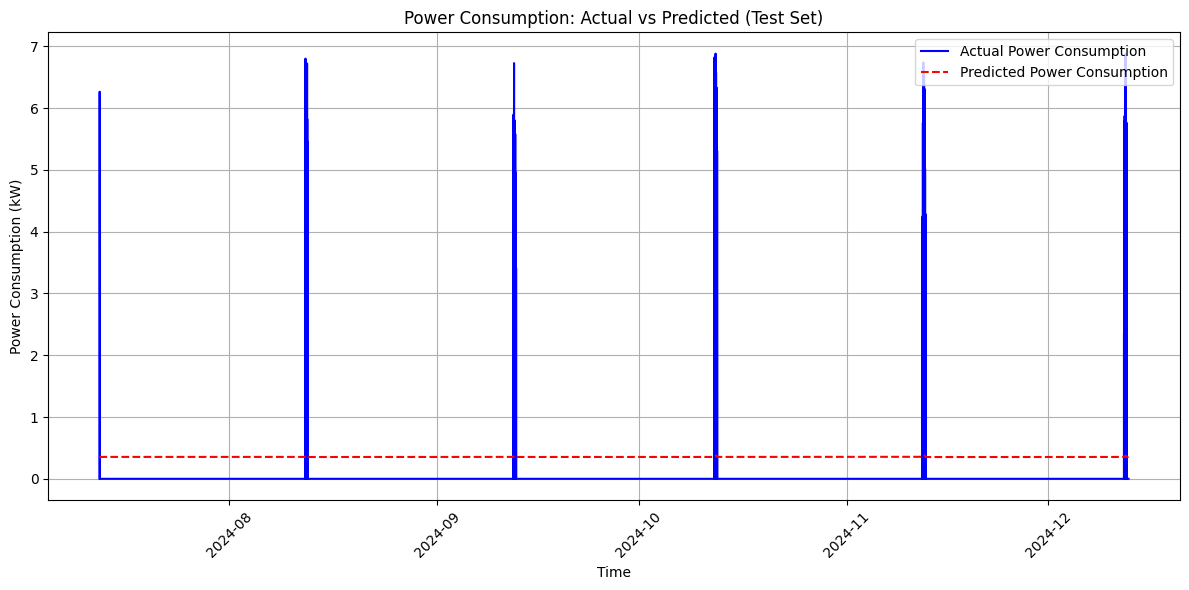

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mlflow
import mlflow.pytorch
import optuna
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_try)

# Define sequence length for 24 hours with 15-minute intervals
sequence_length = 96  # 24 hours * 4 intervals per hour (15-minute intervals)
num_features = len(df_try.columns)  # Use the number of columns for features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i + sequence_length]
    label = scaled_data[i + sequence_length, 2]  # 'Power Consumption (kW)' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays and then to PyTorch tensors
sequences = torch.tensor(np.array(sequences), dtype=torch.float32)
labels = torch.tensor(np.array(labels), dtype=torch.float32)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

# Create data loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Get the output of the last time step
        return out

# Function to train and evaluate the model
def train_and_evaluate(params):
    # Extract hyperparameters from Optuna trial
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']

    model = LSTMModel(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 100
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))  # Reshape target to match output
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target.unsqueeze(1)).item()  # sum up batch loss

        test_loss /= len(test_loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}')
    
    return test_loss

# Optuna Hyperparameter optimization
def objective(trial):
    # Define hyperparameters for optimization
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Log the experiment using MLflow
    mlflow.start_run()
    mlflow.log_param('hidden_size', hidden_size)
    mlflow.log_param('num_layers', num_layers)
    mlflow.log_param('learning_rate', learning_rate)

    test_loss = train_and_evaluate({
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': learning_rate
    })

    mlflow.log_metric('test_loss', test_loss)
    mlflow.end_run()

    return test_loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best hyperparameters from Optuna
print(f"Best trial: {study.best_trial.params}")

# Load best model and evaluate
best_model = LSTMModel(input_size=num_features, 
                       hidden_size=study.best_trial.params['hidden_size'], 
                       num_layers=study.best_trial.params['num_layers'], 
                       output_size=1)

# Log the model to MLflow
mlflow.pytorch.log_model(best_model, 'best_lstm_model')

# Plot the predictions vs actual values
predictions = []
actual_values = []
test_dates = df_try.iloc[train_size + sequence_length:].index

# Predict and collect results
best_model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = best_model(data)
        predictions.append(output.numpy())
        actual_values.append(target.numpy())

predictions = np.concatenate(predictions, axis=0)
actual_values = np.concatenate(actual_values, axis=0)

# Inverse transform the predictions and actual values
predictions_original = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df_try.shape[1]-1)), predictions.reshape(-1, 1)], axis=1))[:, -1]
actual_values_original = scaler.inverse_transform(np.concatenate([np.zeros((actual_values.shape[0], df_try.shape[1]-1)), actual_values.reshape(-1, 1)], axis=1))[:, -1]

# Plot actual vs predicted power consumption
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_values_original, label='Actual Power Consumption', color='blue')
plt.plot(test_dates, predictions_original, label='Predicted Power Consumption', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.title('Power Consumption: Actual vs Predicted (Test Set)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
import mlflow.models.signature
from mlflow.models.signature import infer_signature

# Instantiate the LSTM model
input_size = num_features  # Ensure num_features is defined
hidden_size = 64  # Adjust based on hyperparameter tuning
num_layers = 3
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create an input example for the model (use a single batch of training data)
input_example = train_x[0].unsqueeze(0).to(device).numpy()  # Single batch with one sequence

# Run the model with the input example to generate predictions
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(input_example).to(device))

# Infer the model signature
signature = infer_signature(input_example, predictions.cpu().numpy())

# Log the model with MLflow
mlflow.pytorch.log_model(
    model,
    "lstm_model",
    signature=signature,
    input_example=input_example
)


2025/01/26 21:58:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/26 21:59:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [15]:
import mlflow.models.signature
from mlflow.models.signature import infer_signature

# Ensure the model is on the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create an input example (a single batch of data)
input_example = train_x[0].unsqueeze(0).to(device)  # Ensure input is a PyTorch tensor and matches device

# Run the model on the input example to get predictions
model.eval()
with torch.no_grad():
    prediction_example = model(input_example)

# Infer the model's signature using the input example and prediction
signature = infer_signature(input_example.cpu().numpy(), prediction_example.cpu().numpy())

# Log the model with MLflow, including the signature and input example
mlflow.pytorch.log_model(
    model,
    "lstm_model",
    signature=signature,
    input_example=input_example.cpu().numpy()
)


2025/01/26 22:01:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2025/01/26 22:01:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [17]:
import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature

# Ensure the model is in evaluation mode
model.eval()

# Set the device for the model and example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create an input example
input_example = train_x[0].unsqueeze(0).to(device)

# Perform inference to get prediction
with torch.no_grad():
    prediction_example = model(input_example)

# Infer the model signature
signature = infer_signature(input_example.cpu().numpy(), prediction_example.cpu().numpy())

# End any currently active MLflow run
if mlflow.active_run():
    mlflow.end_run()

# Start a new MLflow run
with mlflow.start_run():
    # Log the model with the signature and input example
    mlflow.pytorch.log_model(
        model,
        "lstm_model",
        signature=signature,
        input_example=input_example.cpu().numpy()
    )
    
    # Get the model URI after logging
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/lstm_model"
    print(f"Model logged to: {model_uri}")
    
    # Register the model to the Model Registry
    mlflow.register_model(
        model_uri=model_uri,
        name="LSTM_Power_Consumption_Model"
    )


2025/01/26 22:03:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run glamorous-moth-797 at: http://127.0.0.1:5000/#/experiments/0/runs/281e6a66a2e24da7a8e339ab74c7ac87
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


2025/01/26 22:03:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'LSTM_Power_Consumption_Model'.
2025/01/26 22:03:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_Power_Consumption_Model, version 1


Model logged to: runs:/17535e818a9b4ec3ab645c1ddb730acb/lstm_model
🏃 View run mysterious-shark-741 at: http://127.0.0.1:5000/#/experiments/0/runs/17535e818a9b4ec3ab645c1ddb730acb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Created version '1' of model 'LSTM_Power_Consumption_Model'.


In [19]:
import mlflow

model_uri = 'runs:/17535e818a9b4ec3ab645c1ddb730acb/lstm_model'
# This is the input example logged with the model
pyfunc_model = mlflow.pyfunc.load_model(model_uri)
input_data = pyfunc_model.input_example

# Verify the model with the provided input data using the logged dependencies.
# For more details, refer to:
# https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
mlflow.models.predict(
    model_uri=model_uri,
    input_data=input_data,
    env_manager="uv",
)

2025/01/26 22:07:34 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2025/01/26 22:07:34 INFO mlflow.utils.virtualenv: Creating a new environment in /tmp/tmpr8kl9lv4/envs/virtualenv_envs/mlflow-2d7d07ba4e730cfab2983d599c2ae1117fec9146 with python version 3.12.1 using uv
Using CPython 3.12.1 interpreter at: /home/codespace/.python/current/bin/python3.12
Creating virtual environment at: /tmp/tmpr8kl9lv4/envs/virtualenv_envs/mlflow-2d7d07ba4e730cfab2983d599c2ae1117fec9146
Activate with: source /tmp/tmpr8kl9lv4/envs/virtualenv_envs/mlflow-2d7d07ba4e730cfab2983d599c2ae1117fec9146/bin/activate
2025/01/26 22:07:34 INFO mlflow.utils.virtualenv: Installing dependencies
Using Python 3.12.1 environment at: /tmp/tmpr8kl9lv4/envs/virtualenv_envs/mlflow-2d7d07ba4e730cfab2983d599c2ae1117fec9146
Resolved 3 packages in 45ms
Prepared 3 packages in 83ms
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
   

{"predictions": [[-0.007006032392382622]]}